# Holistic Results

**TODO**: Fill in the `MRMC_DIR`. This should be a path (absolute or relative) to the repo's top-level directory. It is probably `../../../..`

In [1]:
import sys
import os

MRMC_DIR = '../../../..'

if MRMC_DIR is None:
    raise RuntimeError("MRMC_DIR should have the path to the top-level directory of the MRMC repo.")

In [2]:
sys.path.append(MRMC_DIR)

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import joblib
import json

import matplotlib.pyplot as plt
import seaborn as sns

from scripts import fit_kde
from models import model_loader, model_constants
from data import data_loader
from data.adapters import continuous_adapter

# Preliminaries -- load everything

**TODO**: fill in values for `RECOURSE_METHOD`, `DATASET`, `MODEL`, and `EXPERIMENT_NAME`.

In [3]:
RECOURSE_METHOD = 'mrmc'  # mrmc, dice, or face
DATASET_NAME = 'credit_card_default'  # credit_card_default or give_me_credit
MODEL_TYPE = 'logistic_regression'  # logistic_regression or random_forest
EXPERIMENT_NAME = 'mrmc_holistic'  # typically something like mrmc_holistic or dice_hyperparam
RESULTS_DIR = os.path.join(MRMC_DIR, 'experiment_results', RECOURSE_METHOD, MODEL_TYPE, DATASET_NAME, EXPERIMENT_NAME)

if None in [RECOURSE_METHOD, DATASET_NAME, MODEL_TYPE]:
    raise RuntimeError("Values for RECOURSE_METHOD, DATASET, and MODEL must be provided.")

In [4]:
DATASET, DATASET_INFO = data_loader.load_data(data_loader.DatasetName(DATASET_NAME), split="train")
MODEL = model_loader.load_model(model_constants.ModelType(MODEL_TYPE), data_loader.DatasetName(DATASET_NAME))
ADAPTER = continuous_adapter.StandardizingAdapter(
    label_column = DATASET_INFO.label_column, positive_label=DATASET_INFO.positive_label
).fit(DATASET)

DROP_COLUMNS = ['step_id', 'path_id', 'run_id', 'batch_id']  # columns which are convenient to drop from the path_df

with open(os.path.join(RESULTS_DIR, 'config.json')) as f:
    config_json = json.load(f)

EVAL_SPLIT = config_json['split']
EVAL_DATASET, _ = data_loader.load_data(data_loader.DatasetName(DATASET_NAME), split=EVAL_SPLIT)


#  If using MRMC, load the cluster DF
if RECOURSE_METHOD == 'mrmc':
    cluster_df = pd.read_csv(os.path.join(RESULTS_DIR, 'cluster_df.csv'))
config_df = pd.read_csv(os.path.join(RESULTS_DIR, 'experiment_config_df.csv'))
#  If using FACE, retrieve the distance_threshold and weight_bias from the graph config
if RECOURSE_METHOD == 'face':
    graph_filepaths = config_df.graph_filepath.unique()
    distance_thresholds = []
    weight_biases = []
    for graph_filepath in graph_filepaths:
        graph_config_filepath = os.path.join(MRMC_DIR, graph_filepath[:-4] + '_config.json')
        with open(graph_config_filepath) as f:
            graph_config = json.load(f)
            distance_thresholds.append(graph_config['distance_threshold'])
            weight_biases.append(graph_config['weight_bias'])
    graph_config_df = pd.DataFrame({
        'graph_filepath': graph_filepaths,
        'distance_threshold': distance_thresholds,
        'weight_bias': weight_biases
    })
    config_df = config_df.merge(graph_config_df, how='left', on='graph_filepath')
path_df = pd.read_csv(os.path.join(RESULTS_DIR, f'{RECOURSE_METHOD}_paths_df.csv'))
config_df

,batch_id,run_id,run_seed,cluster_seed,confidence_cutoff,max_iterations,noise_ratio,num_clusters,poi_index,rescale_ratio,step_size,volcano_cutoff,volcano_degree,elapsed_recourse_seconds,elapsed_cluster_seconds
0,639,639,7527,1834823,0.7,50,NaN,3,1304,NaN,1,0.5,2,2.117386,0.363808
1,418,418,7527,1834823,0.7,50,NaN,3,1727,NaN,1,0.5,2,2.177834,0.168837
2,598,598,7527,1834823,0.7,50,NaN,3,25144,NaN,1,0.5,2,6.281284,0.164432
3,821,821,7527,1834823,0.7,50,NaN,3,19660,NaN,1,0.5,2,2.586637,0.169861
4,11,11,7527,1834823,0.7,50,NaN,3,10836,NaN,1,0.5,2,1.648867,0.163452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,250,250,7527,1834823,0.7,50,NaN,3,10611,NaN,1,0.5,2,3.082024,0.896062
1120,633,633,7527,1834823,0.7,50,NaN,3,4276,NaN,1,0.5,2,2.813858,0.386157
1121,827,827,7527,1834823,0.7,50,NaN,3,29682,NaN,1,0.5,2,2.993976,0.393176
1122,228,228,7527,1834823,0.7,50,NaN,3,8781,NaN,1,0.5,2,2.548409,0.412492


## Load or Fit a KDE

In [5]:
KDE_DIRECTORY = os.path.join(MRMC_DIR, 'saved_models/kde')
KDE_FILEPATH = os.path.join(KDE_DIRECTORY, f'{DATASET_NAME}_kde.joblib')

if os.path.exists(KDE_FILEPATH):
    KDE = joblib.load(KDE_FILEPATH)
else:
    KDE = fit_kde.fit_kde(DATASET_NAME, KDE_DIRECTORY)

# Analyze the results
**TODO**: Provide a value for `USE_CACHED_RESULTS`. If you have recently rerun
the experiment, you probably don't want to use a cached analysis.

In [6]:
SPARSITY_EPSILON = 1e-5
USE_CACHED_RESULTS = True

def get_poi_cfes(path_df: pd.DataFrame):
    """Isolate the POIs (Points of Interest) and CFEs (Counterfactual Examples) from the full path results.
    
    POIs and CFEs are listed in the order they originally appear in. There is one POI and one CFE
    for every path that appears in the DataFrame."""
    pathscopy = path_df.copy()
    pathscopy['next_step_id'] = 0
    pathscopy.loc[:,'next_step_id'].iloc[0:-1] = pathscopy.loc[:,'step_id'].iloc[1:]
    cfes = pathscopy[pathscopy.step_id >= pathscopy.next_step_id].drop(columns='next_step_id')
    return pathscopy[pathscopy.step_id == 0].drop(columns='next_step_id'), cfes

def get_sparsity(path: pd.DataFrame):
    """Returns the maximum number of features changed in any single iteration
    along the path."""
    if path.shape[0] == 1:
        return np.nan
    path_sparsity = np.zeros(path.shape[0])
    for i in range(1, path.shape[0]):
        path_sparsity[i] = (np.abs(path.iloc[i] - path.iloc[i - 1]) > SPARSITY_EPSILON).sum()
    return np.max(path_sparsity)

def get_path_length(path: pd.DataFrame):
    """Returns the sum of euclidean distances along the path."""
    total = 0
    for i in range(1, path.shape[0]):
        total += np.linalg.norm(path.iloc[i] - path.iloc[i - 1])
    if total == 0:
        return np.nan
    return total

def get_cfe_distance(path: pd.DataFrame):
    """Returns the euclidean distance between the first and last points in the path."""
    if len(path) == 1:
        return np.nan
    return np.linalg.norm(path.iloc[-1] - path.iloc[0])


def analyze_paths(paths: pd.DataFrame, poi_kdes, cfe_kdes, cfe_probs, config_df):
    """Returns a DataFrame containing per-path results.
    
    Each row corresponds to a specific path. Each column is a result metric.
    
    Args:
        paths: The path_df DataFrame to analyze.
        poi_kdes: The KDE scores for the POIs.
        cfe_kdes: The KDE scores for the CFEs.
        config_df: The experiment_config_df for the experiment."""
    columns = ['run_id', 'path_id', 'success', 'proximity', 'path_length',
               'iteration_count', 'poi_density', 'cfe_density', 
               'actual_sparsity']
    col_idx = {}
    for i, col in enumerate(columns):
        col_idx[col] = i

    results = np.zeros((len(poi_kdes), len(columns)))

    i = 0
    for run_id in paths.run_id.unique():
        run_paths = paths[paths.run_id == run_id]
        for path_id in run_paths.path_id.unique():
            path = ADAPTER.transform(run_paths[run_paths.path_id == path_id].drop(columns=DROP_COLUMNS))
            results[i,col_idx['run_id']] = run_id
            results[i,col_idx['path_id']] = path_id

            desired_proba = config_df[config_df.run_id == run_id].confidence_cutoff.iloc[0]
            actual_proba = cfe_probs[i]

            results[i,col_idx['success']] = 1 if actual_proba >= desired_proba else 0
            results[i,col_idx['path_length']] = get_path_length(path)
            results[i,col_idx['iteration_count']] = len(path)
            results[i,col_idx['proximity']] = get_cfe_distance(path)
            results[i,col_idx['poi_density']] = poi_kdes[i]
            results[i,col_idx['cfe_density']] = cfe_kdes[i]
            results[i,col_idx['actual_sparsity']] = get_sparsity(path)
            i += 1

    return pd.DataFrame(data=results, columns=columns)


cached_results_filepath = os.path.join('.', f'{EXPERIMENT_NAME}_results.csv')
cached_kdes_filepath = os.path.join('.', f'{EXPERIMENT_NAME}_kdes.csv')
if USE_CACHED_RESULTS and os.path.exists(cached_results_filepath):
    print("Load cached result analysis...")
    results = pd.read_csv(cached_results_filepath)
    kde_scores = pd.read_csv(cached_kdes_filepath)
else:
    print("Analyze results...")
    pois, cfes = get_poi_cfes(path_df)
    poi_kdes = KDE.score_samples(ADAPTER.transform(pois.drop(columns=DROP_COLUMNS)))
    cfe_kdes = KDE.score_samples(ADAPTER.transform(cfes.drop(columns=DROP_COLUMNS)))
    kde_df = pd.DataFrame({
        'is_poi': [True] * len(pois) + [False] * len(cfes),
        'is_cfe': [False] * len(pois) + [True] * len(cfes),
        'point_index': list(pois.index) + list(cfes.index),
        'kde': list(poi_kdes) + list(cfe_kdes)
    })

    cfe_probs = MODEL.predict_pos_proba(cfes.drop(columns=DROP_COLUMNS)).to_numpy()

    results = analyze_paths(path_df, poi_kdes, cfe_kdes, cfe_probs, config_df)
    results.to_csv(cached_results_filepath, index=False)
    kde_df.to_csv(cached_kdes_filepath, index=False)

results = results.merge(config_df, how='left', on='run_id')
results

Load cached result analysis...


,run_id,path_id,success,proximity,path_length,iteration_count,poi_density,cfe_density,actual_sparsity,batch_id,...,max_iterations,noise_ratio,num_clusters,poi_index,rescale_ratio,step_size,volcano_cutoff,volcano_degree,elapsed_recourse_seconds,elapsed_cluster_seconds
0,639.0,0.0,1.0,3.984688,4.0,5.0,-2.812780,-0.999626,20.0,639,...,50,NaN,3,1304,NaN,1,0.5,2,2.117386,0.363808
1,639.0,1.0,1.0,4.997418,5.0,6.0,-2.812780,-27.282935,19.0,639,...,50,NaN,3,1304,NaN,1,0.5,2,2.117386,0.363808
2,639.0,2.0,1.0,4.939672,5.0,6.0,-2.812780,-0.954965,20.0,639,...,50,NaN,3,1304,NaN,1,0.5,2,2.117386,0.363808
3,418.0,0.0,1.0,6.958399,7.0,8.0,-1.023444,-0.892392,20.0,418,...,50,NaN,3,1727,NaN,1,0.5,2,2.177834,0.168837
4,418.0,1.0,1.0,4.999041,5.0,6.0,-1.023444,-48.277409,19.0,418,...,50,NaN,3,1727,NaN,1,0.5,2,2.177834,0.168837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3367,228.0,1.0,1.0,4.998549,5.0,6.0,-0.479869,-38.805170,19.0,228,...,50,NaN,3,8781,NaN,1,0.5,2,2.548409,0.412492
3368,228.0,2.0,1.0,3.925042,4.0,5.0,-0.479869,-0.185773,20.0,228,...,50,NaN,3,8781,NaN,1,0.5,2,2.548409,0.412492
3369,278.0,0.0,1.0,6.987270,7.0,8.0,3.087826,-1.172080,20.0,278,...,50,NaN,3,7413,NaN,1,0.5,2,2.007254,0.194427
3370,278.0,1.0,1.0,4.999353,5.0,6.0,3.087826,-25.940585,19.0,278,...,50,NaN,3,7413,NaN,1,0.5,2,2.007254,0.194427


# Success

StEP always succeeds

In [7]:
results.groupby('success').count()

,run_id,path_id,proximity,path_length,iteration_count,poi_density,cfe_density,actual_sparsity,batch_id,run_seed,...,max_iterations,noise_ratio,num_clusters,poi_index,rescale_ratio,step_size,volcano_cutoff,volcano_degree,elapsed_recourse_seconds,elapsed_cluster_seconds
success,,,,,,,,,,,,,,,,,,,,,
1.0,3372,3372,3372,3372,3372,3372,3372,3372,3372,3372,...,3372,0,3372,3372,0,3372,3372,3372,3372,3372


# Iteration count

Some rows have high iteration count. This is because those POIs are outliers.

<Axes: xlabel='iteration_count', ylabel='Count'>

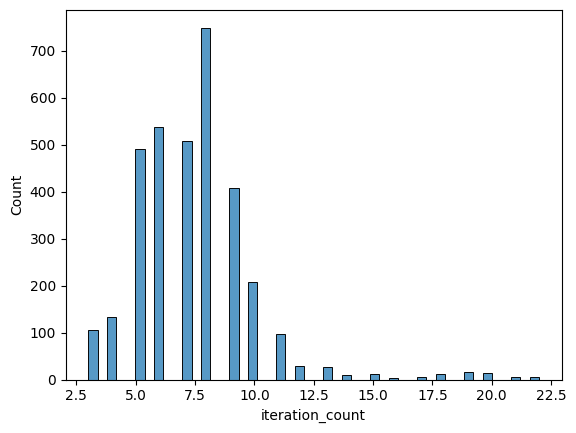

In [8]:
sns.histplot(results, x='iteration_count')

Text(0.5, 1.0, 'Z-Score distribution across full eval set')

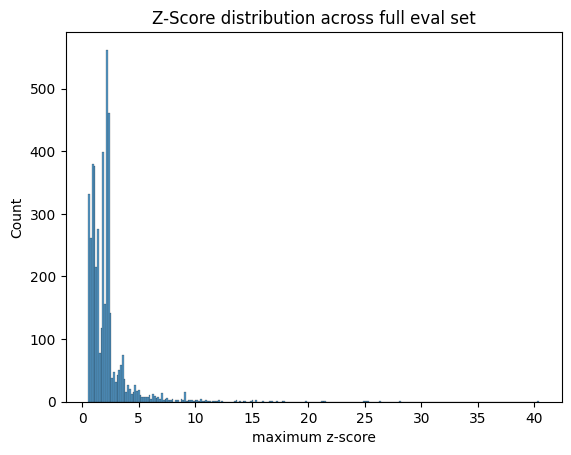

In [9]:
eval_set_zscores = ((EVAL_DATASET - EVAL_DATASET.mean()) / EVAL_DATASET.std()).abs().max(axis=1)
eval_set_zscores.name = 'maximum z-score'
sns.histplot(eval_set_zscores)
plt.title("Z-Score distribution across full eval set")

Text(0.5, 1.0, 'Z-Score distribution across high iteration_count POIs')

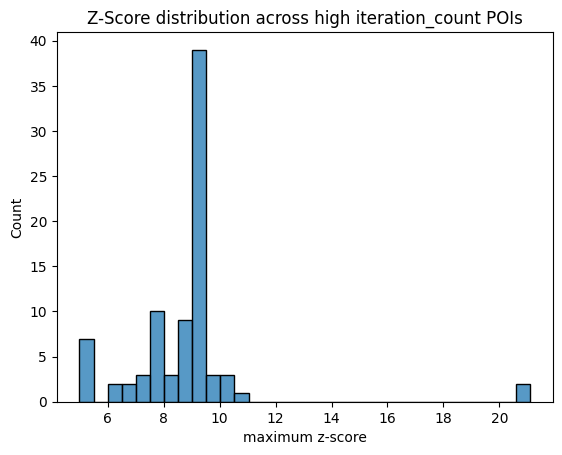

In [10]:
high_iteration_pois = EVAL_DATASET.loc[results[results.iteration_count > 13].poi_index]
high_iteration_zscores = ((high_iteration_pois - EVAL_DATASET.mean()) / EVAL_DATASET.std()).abs().max(axis=1)
high_iteration_zscores.name = 'maximum z-score'
sns.histplot(high_iteration_zscores)
plt.title("Z-Score distribution across high iteration_count POIs")

# Path Length

<Axes: xlabel='path_length', ylabel='Count'>

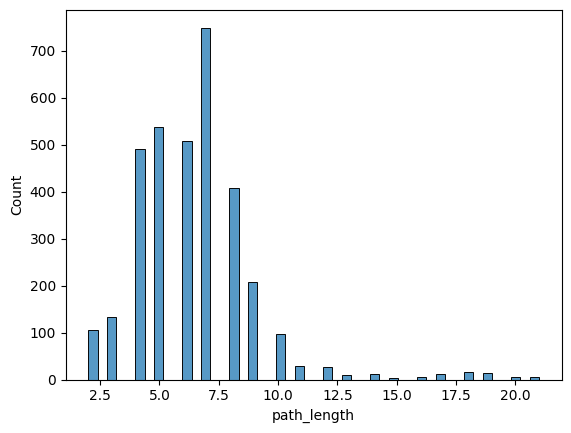

In [11]:
sns.histplot(results, x='path_length')

# Proximity

QUESTION: Why do some points have high proximity?

<Axes: xlabel='proximity', ylabel='Count'>

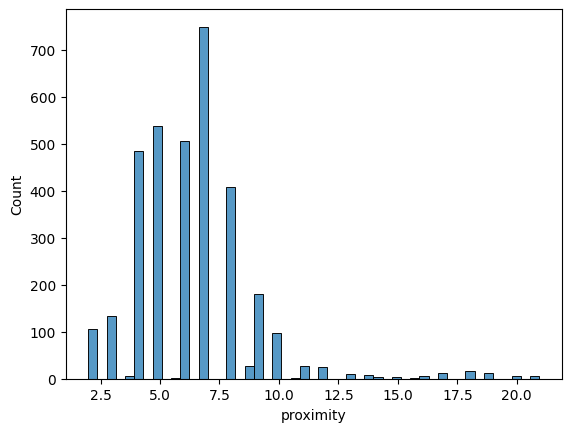

In [12]:
sns.histplot(results, x='proximity')

# Density

(-150.0, 5.0)

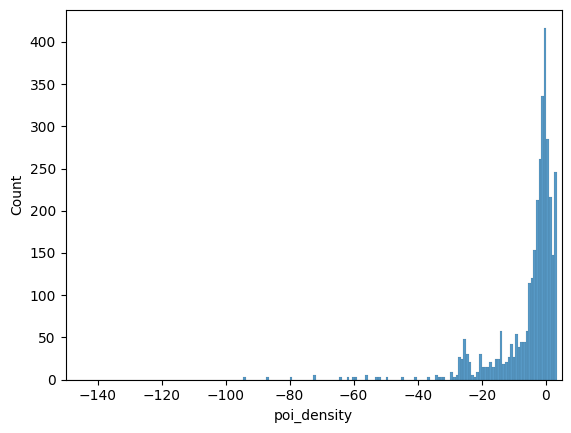

In [13]:
sns.histplot(results, x='poi_density')
plt.xlim(-150, 5)

(-150.0, 5.0)

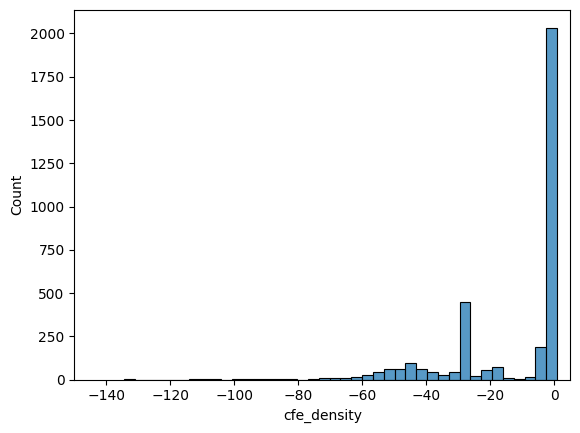

In [14]:
sns.histplot(results, x='cfe_density')
plt.xlim(-150, 5)

In [15]:
results.groupby('path_id').mean()[['cfe_density', 'poi_density', 'proximity']]

,cfe_density,poi_density,proximity
path_id,,,
0.0,-1.815900,-6.427905,7.866690
1.0,-36.312694,-6.427905,5.953762
2.0,-0.990162,-6.427905,5.405412
